<a href="https://colab.research.google.com/github/georgeray1999-CS/CE888_Assignment_2/blob/main/model_code/Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 2 - Tweet Semantics Analysis

This notebook takes the form of first loading in the relevant task data. The data is then prepared for the Naive Bayes, SVM and neural network models. After this, the models are trained and optimized using a grid search algorithm. Different classifers are commented out depending on their task as different tasks require different hyperparameters. Due to the increased number of variables associated with deep neural network structure, a cell exists defining the model for each task. A comment will be provided to indicate which model refers to which task. Some models take some time to train, in this case, a warning will be issued as a comment prior to running the training process. 

## Load Data

Please enure that the relevant training, validation and test csv files for the task have been uploaded to the runtime to allow the following function to load the correct infrmation to be analysed. Please also note that the following code is written for Google Colab, please alter the file path accordingly if using a different IPython environment.

In [21]:
# urls for importing data from GitHub
emotion_base_url = 'https://raw.githubusercontent.com/georgeray1999-CS/CE888_Assignment_2/main/processed_data/emotion/'
offensive_base_url = 'https://raw.githubusercontent.com/georgeray1999-CS/CE888_Assignment_2/main/processed_data/offensive/'
sentiment_base_url = 'https://raw.githubusercontent.com/georgeray1999-CS/CE888_Assignment_2/main/processed_data/sentiment/'

def create_urls(base_url):
  """Add correct path endings to urls"""
  train_url = base_url + 'train_df.csv'
  val_url = base_url + 'validation_df.csv'
  test_url = base_url + 'test_df.csv'

  return [train_url, val_url, test_url]

# change the imput depending on the task to be completed
urls = create_urls(emotion_base_url)

In [22]:
# load data into pandas dataframes
import pandas as pd

def load_data(url_list):
  """This function loads in the data frames created in the pythin scripts to preprocess the data"""

  training_data = pd.read_csv(url_list[0])
  val_data = pd.read_csv(url_list[1])
  test_data = pd.read_csv(url_list[2])

  return training_data, val_data, test_data

training_df, val_df, test_df = load_data(urls)

In [23]:
# run this cell to check the data has been uploaded correctly
training_df

,Text,Target
0,worry down payment problem may never have joyc...,2
1,roommate its okay we cant spell because we hav...,0
2,no but thats cute atsu was probably shy about ...,1
3,rooneys fucking untouchable isnt he been fucki...,0
4,its pretty depressing when u hit pan ur favour...,3
...,...,...
3252,get discouraged because try 5 fucking years co...,3
3253,are contention hosting nation camden empty has...,3
3254,as fellow up grad shiver at shallowness his ar...,0
3255,have hashtag problem yes can do hashtag someth...,0


In [24]:
# convert all data to list format to process
train_tweets = training_df['Text'].tolist()
val_tweets = val_df['Text'].tolist()
test_tweets = test_df['Text'].tolist()

train_labels = training_df['Target'].tolist()
val_labels = val_df['Target'].tolist()
test_labels = test_df['Target'].tolist()

## Text Preprocessing

Classical algorithm preparation

In [25]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# create count vector
count_vector = CountVectorizer()
X_train_counts = count_vector.fit_transform(train_tweets)
X_val_counts = count_vector.transform(val_tweets)
X_test_counts = count_vector.transform(test_tweets)

# transform to tfidf matrix
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_val_tfidf = tfidf_transformer.transform(X_val_counts)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

Neural network data preparation

In [26]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# tokenize tweets
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(train_tweets)

X_train = tokenizer.texts_to_sequences(train_tweets)
X_val = tokenizer.texts_to_sequences(val_tweets)
X_test = tokenizer.texts_to_sequences(test_tweets)

# set vocab size and add 1 to account for 0 padding index
vocab_size = len(tokenizer.word_index) + 1

# print to make make sure process executed as expected
print(train_tweets[0])
print(X_train[0])

# set maximum input length
max_length = 30

# pad out sequences
X_train = pad_sequences(X_train, padding='post', maxlen=max_length)
X_val = pad_sequences(X_val, padding='post', maxlen=max_length)
X_test = pad_sequences(X_test, padding='post', maxlen=max_length)

# make sure sequences padded correctly
print(X_train[0, :])

worry down payment problem may never have joyce meyer hashtag motivation hashtag leadership hashtag worry
[184, 137, 3624, 403, 268, 84, 3, 3625, 3626, 1, 1612, 1, 921, 1, 184]
[ 184  137 3624  403  268   84    3 3625 3626    1 1612    1  921    1
  184    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


In [27]:
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# create numpy array of labels
y_train = np.array(train_labels)
y_val = np.array(val_labels)
y_test = np.array(test_labels)

# one hot encode the labels
oh_encoder = OneHotEncoder()

y_train_coded = oh_encoder.fit_transform((y_train.reshape(len(y_train), 1))).toarray()
y_val_coded = oh_encoder.fit_transform((y_val.reshape(len(y_val), 1))).toarray()
y_test_coded = oh_encoder.fit_transform((y_test.reshape(len(y_test), 1))).toarray()

##Build Models

Naive Bayes

In [ ]:
!pip install hypopt

In [ ]:
# this cell is purely to provie proof of the optimization process, cell below has correct set of hyperparameters
# perform a gridsearch for the best parameters for the NB model
from sklearn.naive_bayes import MultinomialNB
from hypopt import GridSearch
tuned_parameters = [{'alpha': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]}]

clf = GridSearch(model=MultinomialNB(), param_grid=tuned_parameters)

clf.fit(X_train_tfidf, train_labels, X_val_tfidf, val_labels)

In [ ]:
# produce final predictions
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import seaborn as sns

# train optimal model - uncomment to train correct model for task
nb_clf = MultinomialNB(alpha=0.01).fit(X_train_tfidf, train_labels)  # emotion model
# nb_clf = MultinomialNB(alpha=0.08).fit(X_train_tfidf, train_labels)  # offensive model
# nb_clf = MultinomialNB(alpha=0.08).fit(X_train_tfidf, train_labels)  # sentiment model

# predict values
predicted = nb_clf.predict(X_test_tfidf)

# check accuracy
accuracy = accuracy_score(test_labels, predicted)
conf_matrix = confusion_matrix(test_labels, predicted)
print("Accuracy: ", accuracy)

# display macro-F1 score
f1 = f1_score(test_labels, predicted, average='macro')
print("f1 score: ", f1)

# display confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt = ".0f")

SVM

In [ ]:
# this cell is purely to provie proof of the optimization process, cell below has correct set of hyperparameters
# please note that training for offensive and sentiment tasks takes time
# perform a gridsearch for the best parameters for the SVM model
from sklearn.svm import SVC
from hypopt import GridSearch
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

clf = GridSearch(model=SVC(), param_grid=tuned_parameters)

clf.fit(X_train_tfidf, train_labels, X_val_tfidf, val_labels)

In [ ]:
# produce final predictions
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import seaborn as sns

# train optimal model - uncomment to train correct model
svm_clf = SVC(C=1, kernel='linear', gamma=0.0001).fit(X_train_tfidf, train_labels)  # emotion model
# svm_clf = SVC(C=1, kernel='linear', gamma=0.0001).fit(X_train_tfidf, train_labels)  # offensive model
# svm_clf = SVC().fit(X_train_tfidf, train_labels)  # sentiment model

# predict values
predicted = svm_clf.predict(X_test_tfidf)

# check accuracy
accuracy = accuracy_score(test_labels, predicted)
conf_matrix = confusion_matrix(test_labels, predicted)
print("Accuracy: ", accuracy)

# display macro-F1 score
f1 = f1_score(test_labels, predicted, average='macro')
print("f1 score: ", f1)

# display confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt = ".0f")

CNN - LSTM

In [ ]:
# optimized for emotion task
from keras.models import Sequential
from keras.layers import *

embedding_dim = 100

# create model
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D())
model.add(Conv1D(64, 3, activation='relu'))
model.add(MaxPooling1D())
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dense(4, activation='softmax'))

# compile model and print summary
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

# fit model and save history
history = model.fit(X_train, y_train_coded,
                    epochs=10,
                    verbose=1,
                    validation_data=(X_val, y_val_coded),
                    batch_size=10)


In [ ]:
# optimized for offensive task
from keras.models import Sequential
from keras.layers import *

embedding_dim = 100

model = Sequential()

model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))

model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D())

model.add(Bidirectional(LSTM(32)))

model.add(Dense(32, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# compile model an print summary
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

# fit model and save history
history = model.fit(X_train, y_train,
                    epochs=10,
                    verbose=1,
                    validation_data=(X_val, y_val),
                    batch_size=10)

In [ ]:
# optimized for sentiment task
from keras.models import Sequential
from keras.layers import *

embedding_dim = 100

# create model
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D())
model.add(Bidirectional(LSTM(32)))
model.add(Dense(32, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(3, activation='softmax'))

# compile model an print summary
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

# fit model and save history
history = model.fit(X_train, y_train_coded,
                    epochs=2,
                    verbose=1,
                    validation_data=(X_val, y_val_coded),
                    batch_size=10)

Validation and testing results

Training Accuracy: 0.9916
Validation Accuracy:  0.7409
F1 score:  0.39515760621288265


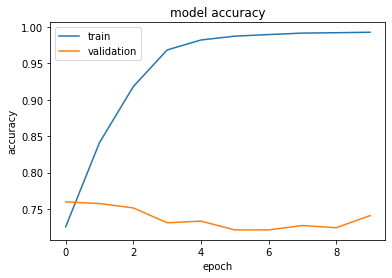

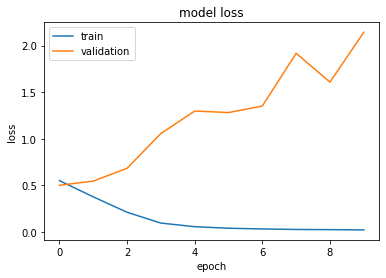

In [ ]:
# please use y_train, y_val and y_test for offensive task an y_train_coded, y_val_coded and y_test_coded for emotion and sentiment tasks

# print training accuracy
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

#print validation accuracy
loss, accuracy = model.evaluate(X_val, y_val, verbose=False)
print("Validation Accuracy:  {:.4f}".format(accuracy))

# find argmax of highest value and return as list
predictions = model.predict(X_val)

# create list of predicted classes - please uncomment as appropriate
# use for emotion and sentiment task
predicted = []
for i in predictions:
  predicted.append(np.argmax(i))

# use for offensive task
# predicted = predictions.round()

# print f1 score
from sklearn.metrics import f1_score
f1 = f1_score(val_labels, predicted, average='macro')
print("F1 score: ", f1)

# plot results
import matplotlib.pyplot as plt

# plot accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
# Final test set results
from sklearn.metrics import confusion_matrix
import seaborn as sns

# find argmax of highest value and return as list
predictions = model.predict(X_test)

# create list of predicted classes - please uncomment as appropriate
# use for emotion and sentiment task
predicted = []
for i in predictions:
  predicted.append(np.argmax(i))

# use for offensive task
# predicted = predictions.round()

# print f1 score
from sklearn.metrics import f1_score
f1 = f1_score(test_labels, predicted, average='macro')
conf_matrix = confusion_matrix(test_labels, predicted)
print("f1 score: ", f1)

# display confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt = ".0f")

## BERT

In [ ]:
!pip install ktrain

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
import ktrain
from ktrain import text

In [6]:
training_df.head()

,Text,Target
0,worry down payment problem may never have joyc...,2
1,roommate its okay we cant spell because we hav...,0
2,no but thats cute atsu was probably shy about ...,1
3,rooneys fucking untouchable isnt he been fucki...,0
4,its pretty depressing when u hit pan ur favour...,3


In [ ]:
# create train and validation set
(X_train, y_train), (X_val, y_val), preprocess = text.texts_from_df(train_df=training_df, 
                   text_column='Text',
                   label_columns='Target',
                   val_df=val_df,
                   maxlen=400,
                   preprocess_mode='bert')

In [8]:
# check correct data loaded
X_train[0].shape

(3257, 400)

In [9]:
# create model
model = text.text_classifier(name='bert',
                             train_data=(X_train, y_train),
                             preproc=preprocess)

Is Multi-Label? False
maxlen is 400
done.


In [10]:
# compile model
learner = ktrain.get_learner(model=model,
                             train_data=(X_train, y_train),
                             val_data=(X_val, y_val),
                             batch_size=6)

In [ ]:
# train model - depending on the task this cell often takes a while to run
learner.fit_onecycle(lr=2e-5, epochs=2)

In [13]:
# get predictions for test set
predictor = ktrain.get_predictor(learner.model, preprocess)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# produce predictions
predicted = predictor.predict(test_tweets)
print(predicted)

# use for emotion
predictions = []
for i in predicted:
  if i == 'Target_0':
    predictions.append(0)
  elif i == 'Target_1':
    predictions.append(1)
  elif i == 'Target_2':
    predictions.append(2)
  elif i == 'Target_3':
    predictions.append(3)

# use for offensive
# predictions = []
# for i in predicted:
#   if i == 'not_Target':
#     predictions.append(0)
#   elif i == 'Target':
#     predictions.append(1)

# use for sentiment
# predictions = []
# for i in predicted:
#   if i == 'Target_0':
#     predictions.append(0)
#   elif i == 'Target_1':
#     predictions.append(1)
#   elif i == 'Target_2':
#     predictions.append(2)

# check results
# print f1 score
from sklearn.metrics import f1_score, recall_score
f1 = f1_score(test_labels, predictions, average='macro')
mar = f1_score(test_labels, predictions, average='macro')
conf_matrix = confusion_matrix(test_labels, predictions)
print("Macro F1 score: ", f1)
print("Macro average recall score: ", mar)

# display confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt = ".0f")

In [15]:
# save model
predictor.save('/content/bert')

In [ ]:
# functionality to reload model
predictor_loaded = ktrain.load_predictor('/content/bert')
predicted = predictor_loaded.predict(test_tweets)
print(predicted)